In [5]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt

# Introduction

It is of great interests in biology and psychology to understand factors of affecting children's (preschoolers) cognitive abilities relating to their mothers. We are given a data set of children's cognitive test scores as well as characteristics of their mother. 
The goal is to predict the child's IQ (cognitive test scores) based on the characteristics of his/her mother. In particular, we will apply linear regression models using child's IQ as the regressand and the features of the mother as regressors. Based on the models, we are able to produce insights on how the mother affects the child's IQ. 
Finally, we assume the readers of this notebook are familiar with basic statistical analysis.

# Loading Data

We have the following specification of data:

* i - mother's IQ
* a - mother's age at child's birth
* h - indicator showing whether mother completed high school (1=True, 0=False)
* w = 1: mother did not work in first three years of child’s life
* w = 2: mother worked in second or third year of child’s life
* w = 3: mother worked part-time in first year of child’s life
* w = 4: mother worked full-time in first year of child’s life
* score - child's IQ (regressand)

Based on the specification, we define constants corresponding to the variable names.

In [1]:
CHILD_IQ = 'score'
MOTHER_IQ = 'i'
MOTHER_AGE_AT_CHILD_BIRTH = 'a'
MOTHER_COMPLETED_HIGH_SCHOOL = 'h'
WHEN_MOTHER_WORK_IN_THREE_YEAR = 'w'

By taking a look at the data file `data.txt`, we see that the row format is `line number|variable|value`. In particular, the data set list all the rows with the same variable consecutively, i.e., it starts with all `score` values, and then all the `h` values, etc. We pressume that the values of every variable are given in the same order, so that i-th value of a variable belongs to the i-th person. With this in mind, we load the data file line by line.

We assign each variable with the following data type:
* child's IQ: float
* mother's IQ: float
* mother's age at child birth: integer
* indicator showing whether mother completed high school: integer (treated as categorical later)
* how the mother work in the first three years: string (treated as categorical later)

Basically, the value of IQ and age are naturally numerical. Although the boolean type is more natural, we assign · indicator showing whether mother completed high school with integer type, because values are 0-1 binary, which encodes whether this feature is active and makes it easier to be included in regression models. The last feature is clearly categorical, and it does not seem to have a natural ordering, especially when we consider predicting child's IQ. This will be confirmed in exploratory data analysis. Later, we may consider collapsing some categories for the last feature and encoding this variable with one-hot encoding if necessary.

Note: `data.txt` contains none `utf-8` characters, so we decode the file with `latin1`, which basically can read any characters.

In [2]:
mother_IQ = []
mother_age_at_child_birth = []
mother_completed_high_school = []
when_mother_work_in_three_year = []
child_IQ = []

with open('data.txt', mode='r', encoding='latin1') as f:
    next(f) # skip header
    for line in f:
        _, variable, value = line.strip().split('|')
        if variable == CHILD_IQ:
            child_IQ.append(float(value))
            
        elif variable == MOTHER_IQ:
            value = value[1:-1]
            mother_IQ.append(float(value))
            
        elif variable == MOTHER_AGE_AT_CHILD_BIRTH:
            mother_age_at_child_birth.append(int(value))
            
        elif variable == MOTHER_COMPLETED_HIGH_SCHOOL:
            mother_completed_high_school.append(int(value))
            
        elif variable == WHEN_MOTHER_WORK_IN_THREE_YEAR:
            when_mother_work_in_three_year.append('w='+(value))

We make sure that every variable has the same number of values, which is the number of mother-child pairs in this data set. It also suggests that there are no missing values.

In [3]:
print(len(child_IQ))
print(len(mother_IQ)) 
print(len(mother_age_at_child_birth))
print(len(mother_completed_high_school))
print(len(when_mother_work_in_three_year))

434
434
434
434
434


# Exploratory Data Analysis

We create a pandas dataframe for exploratory data analysis. Note that we treat `indicator showing whether mother completed high school` and `how the mother worked in the first three years` as categorical variables so that pandas will not use analytics techniques for numerical values on them.

In [6]:
data = {
    'mother_IQ': mother_IQ,
    'mother_age_at_child_birth': mother_age_at_child_birth,
    'completed_high_school': pd.Categorical(mother_completed_high_school),
    'when_mother_work': pd.Categorical(when_mother_work_in_three_year),
    'child_IQ': child_IQ
}

df = pd.DataFrame.from_dict(data)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   mother_IQ                  434 non-null    float64 
 1   mother_age_at_child_birth  434 non-null    int64   
 2   completed_high_school      434 non-null    category
 3   when_mother_work           434 non-null    category
 4   child_IQ                   434 non-null    float64 
dtypes: category(2), float64(2), int64(1)
memory usage: 11.5 KB


## Univariate exploratory data analysis

For each of the numerical variable, we look at the min, the max, the mean, the standard deviation, the 25%-75% quantiles. We also plot the histogram to show the distributions. Basically, the distributions are unimodal, and there are no obvious outliers. The distribution of `mother's IQ` is slightly right-skewed, and that of `child's IQ` is slightly left-skewed. The mode of `mother's IQ` is around 85 ~ 90, while the mode of `child's IQ` is around 100. The mode of `mother's age at child's birth` is around 23 ~ 24.

In [8]:
df.describe()

,mother_IQ,mother_age_at_child_birth,child_IQ
count,434.000000,434.000000,434.000000
mean,100.000000,22.785714,86.797235
std,15.000000,2.701070,20.410688
min,71.037405,17.000000,20.000000
25%,88.660321,21.000000,74.000000
50%,97.915254,23.000000,90.000000
75%,110.272742,25.000000,102.000000
max,138.893106,29.000000,144.000000


array([[<AxesSubplot:title={'center':'mother_IQ'}>,
        <AxesSubplot:title={'center':'mother_age_at_child_birth'}>],
       [<AxesSubplot:title={'center':'child_IQ'}>, <AxesSubplot:>]],
      dtype=object)

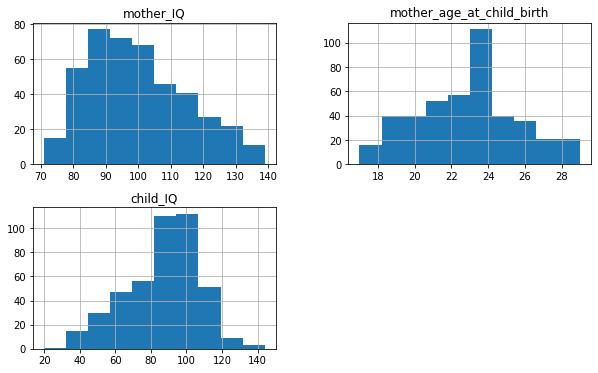

In [9]:
df.hist(figsize=(10, 6))

Next, we look at the categorical variables. We basically look at the distribution different categories. Notice that categories are imbalanced. There are significantly more mothers working full-time during the first yeer of child's left than other kinds of mother. Similarly, there are much more mothers who completed high school than those who did not. Imbalanced categories will affect strongly the quality of the variable as a feature, since most models will be likely to focus more on the majority. As a result, predictions on the minority are much less reliable. However, we can consider collapsing the category w=1, w=2 with w=3, since by collapsing, the imbalance of categories is mitigated, and the new variable has a natural interpretation: `whether the mother worked full time first year at child's birth`. We will explore this more in the linear regression section below.

In [422]:
df[['completed_high_school', 'when_mother_work']].describe()

,completed_high_school,when_mother_work
count,434,434
unique,2,4
top,1,w4
freq,341,205


<AxesSubplot:>

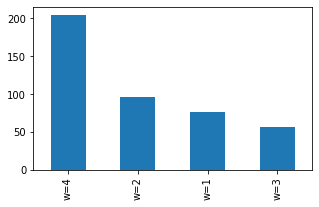

In [546]:
df['when_mother_work'].value_counts().plot(kind = 'bar', figsize=(5, 3))

<AxesSubplot:>

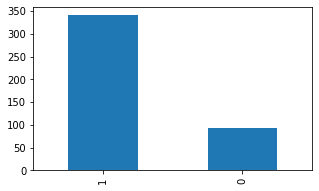

In [547]:
df['completed_high_school'].value_counts().plot(kind = 'bar', figsize=(5, 3))

## Multivariate exploratory data analysis

Next, we perform exploratory data analysis for multiple variables. First, we produce scatter plots for each pair of numerical variables. It is clear that `mother's IQ` and `child's IQ` has a positive correlation, which may suggest that cognitive abilities have a genetic component. This findiing will also be our starting point for linear regresions. 

array([[<AxesSubplot:xlabel='mother_IQ', ylabel='mother_IQ'>,
        <AxesSubplot:xlabel='mother_age_at_child_birth', ylabel='mother_IQ'>,
        <AxesSubplot:xlabel='child_IQ', ylabel='mother_IQ'>],
       [<AxesSubplot:xlabel='mother_IQ', ylabel='mother_age_at_child_birth'>,
        <AxesSubplot:xlabel='mother_age_at_child_birth', ylabel='mother_age_at_child_birth'>,
        <AxesSubplot:xlabel='child_IQ', ylabel='mother_age_at_child_birth'>],
       [<AxesSubplot:xlabel='mother_IQ', ylabel='child_IQ'>,
        <AxesSubplot:xlabel='mother_age_at_child_birth', ylabel='child_IQ'>,
        <AxesSubplot:xlabel='child_IQ', ylabel='child_IQ'>]], dtype=object)

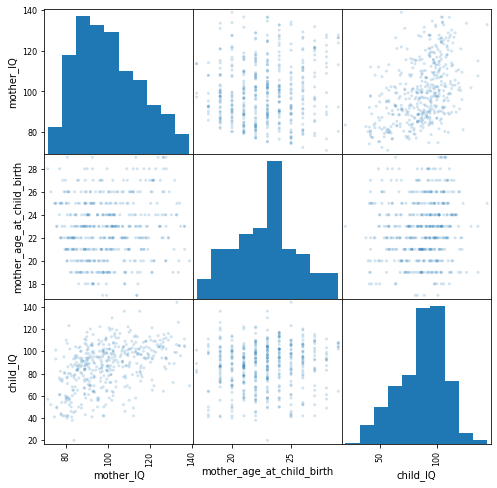

In [298]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(8,8))

For the categorical variable, we look at whether conditioned on different categories, `child's IQ`, `mother's IQ` and `mother's age at child's birth` will have a different distribution. In particular, we see that the relatinoship of `when mother works in the first three year of child life` on IQ is not clear, and we cannot order these categories in an interpretible way.

On the other hand, we see that `child's IQ`, `mother's IQ` and `mother's age at child's birth` is slightly higher on average when the mother completed high school. 

array([<AxesSubplot:title={'center':'child_IQ'}, xlabel='[when_mother_work]'>,
       <AxesSubplot:title={'center':'mother_IQ'}, xlabel='[when_mother_work]'>],
      dtype=object)

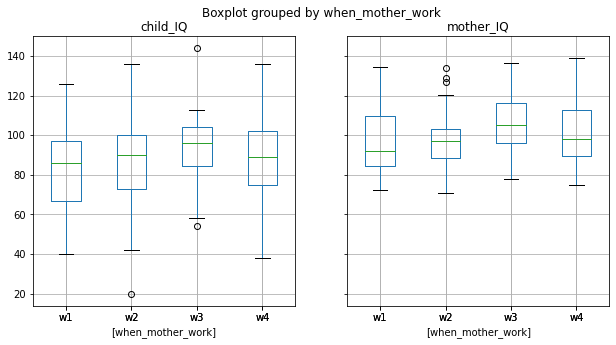

In [426]:
df[['child_IQ', 'mother_IQ', 'when_mother_work']].boxplot(by='when_mother_work', figsize=(10, 5))

array([<AxesSubplot:title={'center':'child_IQ'}, xlabel='[completed_high_school]'>,
       <AxesSubplot:title={'center':'mother_IQ'}, xlabel='[completed_high_school]'>],
      dtype=object)

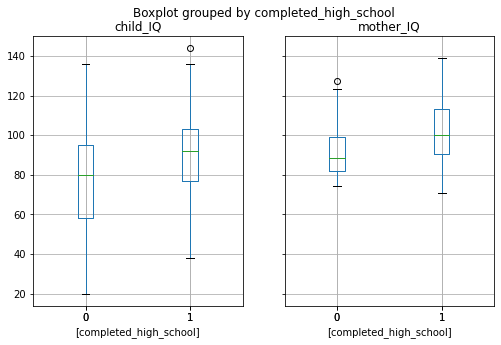

In [300]:
df[['child_IQ', 'mother_IQ', 'completed_high_school']].boxplot(by='completed_high_school', figsize=(8, 5))

<AxesSubplot:title={'center':'mother_age_at_child_birth'}, xlabel='[when_mother_work]'>

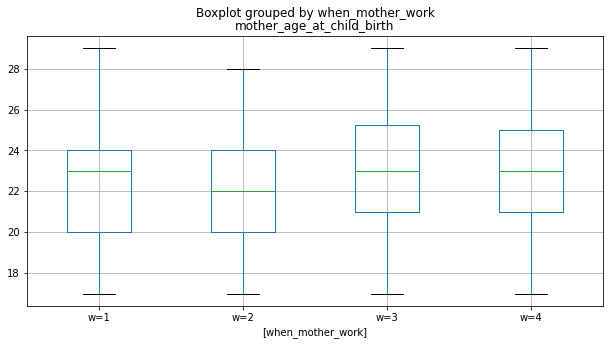

In [10]:
df[['mother_age_at_child_birth', 'when_mother_work']].boxplot(by='when_mother_work', figsize=(10, 5))

<AxesSubplot:title={'center':'mother_age_at_child_birth'}, xlabel='[completed_high_school]'>

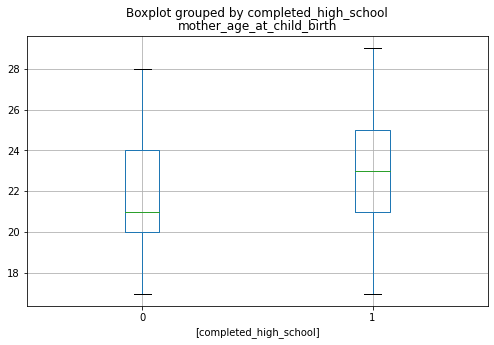

In [11]:
df[['mother_age_at_child_birth', 'completed_high_school']].boxplot(by='completed_high_school', figsize=(8, 5))

# Linear Regression Modeling

## Linear regression with a single predictor

We start with selecting one variable as a single predictor for predicting `child's IQ` using linear regression. Based on the multivariate exploratory data analysis, we already observed that `child's IQ` and `mother's IQ` are positive correlated from the scatter plot. Therefore, we apply linear regression on `child's IQ` with respect to `mother's IQ`, as we make the following standard assumptions on the linear regresion model:

* The relationship between `child's IQ` and `mother's IQ` is linear.
* The residuals follow a normal distribution with mean 0 with a fixed variance.

We will verify these assumptions and conclude model significance by looking at diagnostics of the model.

In [13]:
X1, y1 = df['mother_IQ'], df['child_IQ']
model1 = sm.OLS(y1, sm.add_constant(X1))
res1 = model1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:               child_IQ   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.6
Date:                Fri, 20 Jan 2023   Prob (F-statistic):           7.66e-23
Time:                        11:01:49   Log-Likelihood:                -1875.6
No. Observations:                 434   AIC:                             3755.
Df Residuals:                     432   BIC:                             3763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7998      5.917      4.360      0.0

### Diagonostics
We plot the fitted line to illustrate the potential linear relationship.

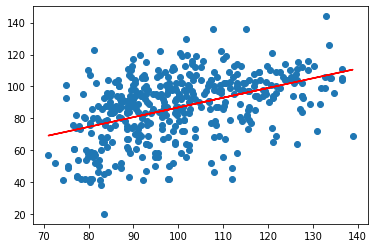

In [14]:
plt.plot(X1, res1.predict(sm.add_constant(X1)), color='red')
plt.scatter(X1, y1)


To check the assumptions, the key step is to examine the distribution of the residuals. The plot shows that residuals are center around and concentrate near 0, and the spread of residuals is relatively the same for different values of predictors. To actually verify the normality of the distribution, we plot the QQ-plot of the residuals, which confirms the normality, since most of the residuals are on the line representing the normal distributions, having the same quantiles.

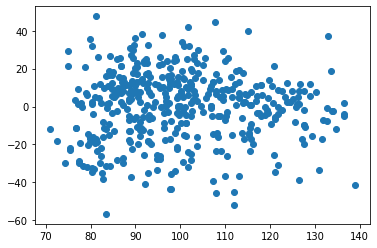

In [15]:
plt.scatter(X1, res1.resid)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


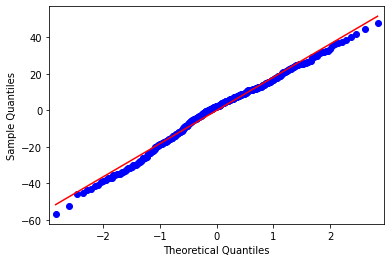

In [16]:
fig = sm.qqplot(res1.resid, line='s')
plt.show()

### Evaluation
Since we verify the normality of the residuals, the t-test on the significance of the coefficient and the coefficient confidence interval are justified. In particular, the p-value of the t-statistics is less than 0.0001, and the interval of the confidence interval is narrow and away from 0. We can conclude that the model is significant, and there is a linear relation between `child's IQ` and `mother's IQ`.


## Linear regression with multiple predictors

We consider linear regressions with respect to multiple predictors. As mentioned in exploratory data analysis, in order to make use of `how the mother worked in the first three years` as a predictor, we collapse `w=1`, `w=2` and `w=3` into one category, which represents `not working full time in first year of child life`. As a result, the variable becomes binary. Now we regress `child's IQ` with respect to `mother's IQ`, `whether mother completed high school` and `whether mother worked fulltime at first year of child's life`. 

Basically, we make the following assumptions:

* `child's IQ` depends linearly on the other variables: `mother's IQ`, `whether mother completed high school` and `whether mother worked fulltime at first year of child's life`.
* The residuals follow a normal distribution with mean 0 with a fixed variance.
* The regressors are independent, i.e., no serious multicolinearity exist.

Note: we also tried one-hot encoding of `how mother worked in first three years of child's life` and/or included `mother's age at child's birth`. The design matrix became numerically unstable. 

In [17]:
new_df = df.copy()
new_df['mother_work_fulltime'] = new_df['when_mother_work'].apply(lambda x: 1 if x == 'w=4' else 0)

In [18]:
X2 = new_df[['mother_IQ', 'completed_high_school', 'mother_work_fulltime']]
y2 = new_df['child_IQ']
model2 = sm.OLS(y2, sm.add_constant(X2))
res2 = model2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:               child_IQ   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     39.25
Date:                Fri, 20 Jan 2023   Prob (F-statistic):           1.95e-22
Time:                        11:03:45   Log-Likelihood:                -1871.8
No. Observations:                 434   AIC:                             3752.
Df Residuals:                     430   BIC:                             3768.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    26.07

### Diagnostics

We check the residuals and the corresponding QQ-plot as in the previous case, which verifies the linear dependence and normality assumptions. 
If multicolinearity is present, the summary will report it in the `Notes`. Alternatively, one can also check the variance influence factor if necessary. 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


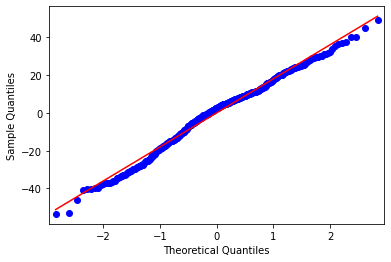

In [19]:
fig = sm.qqplot(res2.resid, line='s')
plt.show()

### Evaluation

Again, we examine the t-test of the coefficients. We can see that `mother IQ` and `whether mother completed high school` are significant predictors based on the small p-value, and they both have a positive correlation with `child IQ`. On the other hand, `whether the mother worked full-time in first three years of child birth` is insignificant based on the large p-value.

## Linear regression with multiple predictors with an interaction term

Based on the previous section, we know that `mother's IQ` and `whether mother completed high school` are significant predictors. We want to introduce an interaction term between `mother‘s IQ` and `whether mother worked full time at first year of child's life`. This idea is supported by looking at the linear regression of `child's IQ` with respect to `mother's IQ` conditioning on `whether mother worked full time at first year of child's life`, where the slopes look different.


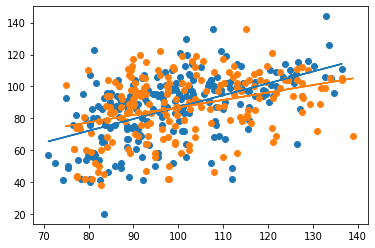

In [20]:
X0 = new_df[new_df['mother_work_fulltime'] == 1]['mother_IQ']
y0 = new_df[new_df['mother_work_fulltime'] == 1]['child_IQ']
model400 = sm.OLS(y0, sm.add_constant(X0))
res400 = model400.fit()


X1 = new_df[new_df['mother_work_fulltime'] == 0]['mother_IQ']
y1 = new_df[new_df['mother_work_fulltime'] == 0]['child_IQ']
model401 = sm.OLS(y1, sm.add_constant(X1))
res401 = model401.fit()


plt.plot(X1, res401.predict(sm.add_constant(X1)))
plt.scatter(X1, y1)
plt.plot(X0, res400.predict(sm.add_constant(X0)))
plt.scatter(X0, y0)

Now we add the interaction term as a predictor. Basically, we make the following assumptions:

* `child's IQ` depends linearly on the other variables: `mother's IQ`, `whether mother completed high school` and the interaction between `mother's IQ` and `whether mother worked fulltime at first year of child's life`.
* The residuals follow a normal distribution with mean 0 with a fixed variance.
* The regressors are independent, i.e., no serious multicolinearity exist.

In [21]:
new_df['mother_IQ_and_full_time'] = new_df['mother_IQ'] * new_df['mother_work_fulltime']

In [22]:
X3 = new_df[['mother_IQ', 'completed_high_school', 'mother_IQ_and_full_time']]
y3 = new_df['child_IQ']
model3 = sm.OLS(y3, sm.add_constant(X3))
res3 = model3.fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:               child_IQ   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     39.47
Date:                Fri, 20 Jan 2023   Prob (F-statistic):           1.51e-22
Time:                        11:06:21   Log-Likelihood:                -1871.5
No. Observations:                 434   AIC:                             3751.
Df Residuals:                     430   BIC:                             3767.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Diagnostics

We may draw QQ plot of residuals again, but assumptions are verified in the same way as above. 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


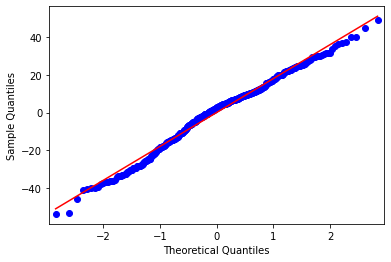

In [23]:
fig = sm.qqplot(res3.resid, line='s')
plt.show()

## Evaluation

Again, based on the p-value, `mother's IQ` and `whether mother completed high school` are significant predictors, while the interaction between `mother's IQ` and `whether mother worked full time at first year of child's life` is not significant. 

# Conclusion

In conclusion, `mother's IQ` and `whether mother completed high school` have a significant positive correlation with `child's IQ` based on linear regression models above. This result is in consistency with our common sense. 